<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/Computer_Vision_with_TF_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

In [2]:
#this is how we split the train set for validation (this is ok if all we want to do validation)
(dataset_train_original,dataset_validate_original), info = tfds.load(
    "cifar10",
    split = ["train","test"],
    as_supervised = True, # with this, each sample will be an x, y pair
    with_info = True
)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete534OCJ/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete534OCJ/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {

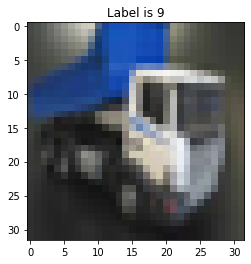

In [3]:
#as_supervised=True, so take() returns directly x and y 
for x,y in dataset_train_original.shuffle(100).take(1):
  plt.imshow(x.numpy().squeeze(),cmap="gray")
  plt.title(f"Label is {y}")

0.97647065


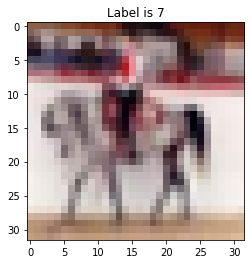

In [4]:
def encode(image,label):
  #this call converts to float, but also normalizes (min-max) becomes (0-1):
  image = tf.image.convert_image_dtype(image,dtype=tf.float32)
  return image, label

dataset = dataset_train_original.map(lambda image, label:encode(image,label))

for x,y in dataset.take(1):
  plt.imshow(x.numpy().squeeze(),cmap="gray")
  plt.title(f"Label is {y}")
  print(np.max(x.numpy()))

In [5]:
#processing steps that will be execuded with each take() call. But by using cache(), the encoding happens only once
dataset_train = dataset_train_original.map(lambda image, label: encode(image,label)).cache().shuffle(60000).batch(128)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image,label)).cache().batch(128)

In [6]:
for x_batch,y_batch in dataset_train.take(1):
  print(x_batch.shape)

(128, 32, 32, 3)


In [7]:
def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(
    8, #number of different kernels to use (or channels). This is a tunable hyperparameter 
    (3,3), #kernel size. Again, tunable hp 
    activation = "relu", #here we just need a nonlinear act function. relu is fast, so better than sigmoid
    input_shape = (32,32,3)
    )) 
    #note that after the convolution we expanded our original data size:
    # output shape of the conv layer = (26,26,8) whereas the original was (28,28,1))
    # so we can think of convolution layer as feature engineering (addition) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation="softmax"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 512)               0

Epoch 1/20
391/391 [==============================] - 13s 9ms/step - loss: 1.7725 - accuracy: 0.3575 - val_loss: 1.5414 - val_accuracy: 0.4430
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 1.4657 - accuracy: 0.4741 - val_loss: 1.4456 - val_accuracy: 0.4801
Epoch 3/20
391/391 [==============================] - 2s 6ms/step - loss: 1.3766 - accuracy: 0.5087 - val_loss: 1.3567 - val_accuracy: 0.5155
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 1.3170 - accuracy: 0.5323 - val_loss: 1.3067 - val_accuracy: 0.5327
Epoch 5/20
391/391 [==============================] - 2s 5ms/step - loss: 1.2728 - accuracy: 0.5504 - val_loss: 1.2616 - val_accuracy: 0.5480
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 1.2306 - accuracy: 0.5652 - val_loss: 1.2440 - val_accuracy: 0.5531
Epoch 7/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1991 - accuracy: 0.5776 - val_loss: 1.2149 - val_accuracy: 0.5669
Epoch

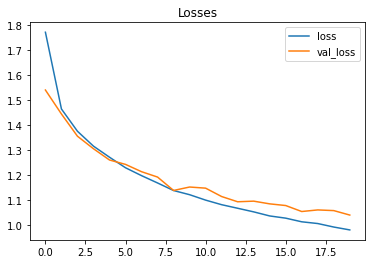

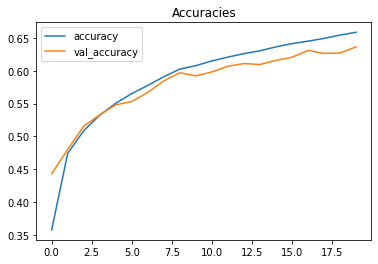

In [11]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validate,
    epochs = 20
)
render_history(history)

#2nd model version

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(
    16, #number of different kernels to use (or channels). This is a tunable hyperparameter 
    (3,3), #kernel size. Again, tunable hp 
    activation = "relu", #here we just need a nonlinear act function. relu is fast, so better than sigmoid
    input_shape = (32,32,3),
    padding="same"
    )) 
    #note that after the convolution we expanded our original data size:
    # output shape of the conv layer = (26,26,8) whereas the original was (28,28,1))
    # so we can think of convolution layer as feature engineering (addition) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(256, (3,3), activation="relu",padding="same"))
model.add(layers.Conv2D(512, (3,3), activation="relu",padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation="softmax"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 4, 4, 128)      

Epoch 1/20
391/391 [==============================] - 5s 11ms/step - loss: 1.5097 - accuracy: 0.4466 - val_loss: 1.1439 - val_accuracy: 0.5869
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 1.0403 - accuracy: 0.6303 - val_loss: 0.9797 - val_accuracy: 0.6557
Epoch 3/20
391/391 [==============================] - 4s 10ms/step - loss: 0.8289 - accuracy: 0.7089 - val_loss: 0.8758 - val_accuracy: 0.6928
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 0.6907 - accuracy: 0.7581 - val_loss: 0.7783 - val_accuracy: 0.7270
Epoch 5/20
391/391 [==============================] - 4s 10ms/step - loss: 0.5579 - accuracy: 0.8043 - val_loss: 0.7696 - val_accuracy: 0.7381
Epoch 6/20
391/391 [==============================] - 5s 11ms/step - loss: 0.4453 - accuracy: 0.8431 - val_loss: 0.7417 - val_accuracy: 0.7557
Epoch 7/20
391/391 [==============================] - 4s 11ms/step - loss: 0.3373 - accuracy: 0.8821 - val_loss: 0.7810 - val_accuracy: 0.7593

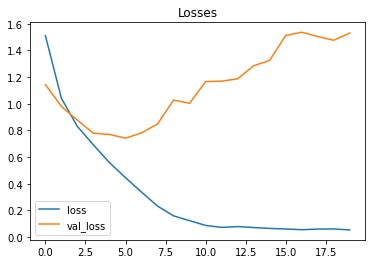

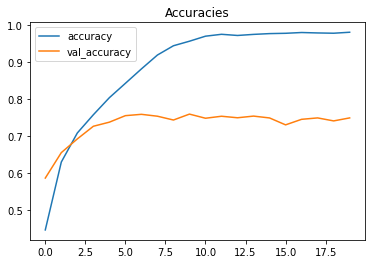

In [32]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validate,
    epochs = 20
)
render_history(history)

# 3rd Try

In [36]:
model = models.Sequential()
model.add(layers.Dropout(
    rate=0.0, #amount to drop out
    input_shape = (32,32,3)
    ))
model.add(layers.Conv2D(
    16, #number of different kernels to use (or channels). This is a tunable hyperparameter 
    (3,3), #kernel size. Again, tunable hp 
    activation = "relu", #here we just need a nonlinear act function. relu is fast, so better than sigmoid
    #input_shape = (32,32,3),
    padding="same"
    )) 
    #note that after the convolution we expanded our original data size:
    # output shape of the conv layer = (26,26,8) whereas the original was (28,28,1))
    # so we can think of convolution layer as feature engineering (addition) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(rate=0.1,input_shape = (32,32,3)))
model.add(layers.Conv2D(64, (3,3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(rate=0.2,input_shape = (32,32,3)))
model.add(layers.Conv2D(128, (3,3), activation='relu',padding="same"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(rate=0.3,input_shape = (32,32,3)))
model.add(layers.Conv2D(256, (3,3), activation="relu",padding="same"))
#model.add(layers.Conv2D(512, (3,3), activation="relu",padding="same"))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.4,input_shape = (32,32,3)))
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(10,activation="softmax"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_21 (Dropout)        (None, 32, 32, 3)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_69 (Conv2D)          (None, 16, 16, 64)        9280      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

Epoch 1/10
391/391 [==============================] - 4s 9ms/step - loss: 1.6166 - accuracy: 0.4018 - val_loss: 1.2527 - val_accuracy: 0.5539
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.2125 - accuracy: 0.5634 - val_loss: 1.0880 - val_accuracy: 0.6177
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.0522 - accuracy: 0.6231 - val_loss: 0.9515 - val_accuracy: 0.6616
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.9506 - accuracy: 0.6615 - val_loss: 0.8669 - val_accuracy: 0.6971
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8735 - accuracy: 0.6915 - val_loss: 0.8158 - val_accuracy: 0.7159
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8179 - accuracy: 0.7086 - val_loss: 0.7945 - val_accuracy: 0.7176
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.7766 - accuracy: 0.7267 - val_loss: 0.7273 - val_accuracy: 0.7444
Epoch 

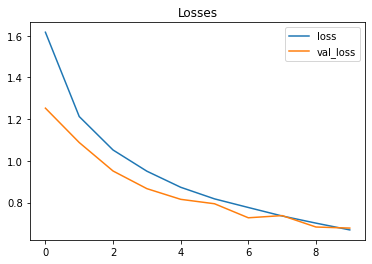

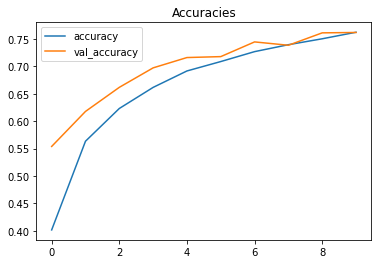

In [37]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validate,
    epochs = 10
)
render_history(history)

Epoch 1/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6396 - accuracy: 0.7724 - val_loss: 0.6489 - val_accuracy: 0.7732
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 0.6200 - accuracy: 0.7793 - val_loss: 0.6401 - val_accuracy: 0.7801
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5962 - accuracy: 0.7866 - val_loss: 0.6369 - val_accuracy: 0.7767
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5680 - accuracy: 0.7976 - val_loss: 0.6831 - val_accuracy: 0.7605
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5514 - accuracy: 0.8031 - val_loss: 0.6052 - val_accuracy: 0.7922
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5344 - accuracy: 0.8092 - val_loss: 0.6333 - val_accuracy: 0.7801
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.5226 - accuracy: 0.8135 - val_loss: 0.6253 - val_accuracy: 0.7837
Epoch

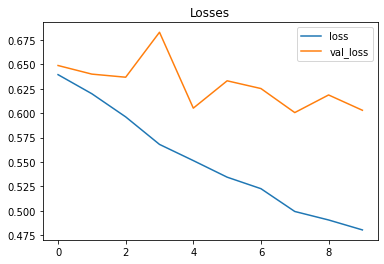

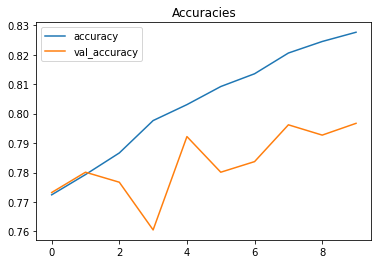

In [38]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validate,
    epochs = 10
)
render_history(history)